# Hands-on Lab --- Churn Modeling

## Importing some standard packages, as well as packages needed for modeling:

In [1]:
import numpy as np
import pandas as pd
import sklearn as sk
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import (RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor,
RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier)
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn import metrics

from sklearn.feature_selection import SelectFromModel

import statsmodels.api as sm

## import modeling data created in the Data Prep pipeline

In [2]:
combined_df = pd.read_csv('E:\OSU_CLV_Course\All_NEW_Fall_2018\Lab\combined_data.csv')

## Using the head method to preview our data:

In [3]:
combined_df.head()

,ST,Zip,DMA,Area_Cd,emailable,solicit_ph_ind,solicit_email_ind,fixd_incm_flg,scheduled_purchase_flg,months_since_last_trans,...,tier_2-Silver,tier_3-Gold,tier_4-Platinum,tier_5-Diamond,tier_prev_1-Bronze,tier_prev_2-Silver,tier_prev_3-Gold,tier_prev_4-Platinum,tier_prev_5-Diamond,tier_prev_xxx
0,VA,23464,544,missing,0,0,1,0,0,2,...,0,1,0,0,0,0,0,0,0,1
1,NC,27542,560,919,1,1,1,0,0,4,...,0,0,0,1,0,0,1,0,0,0
2,NV,89109,839,702,0,0,1,0,0,8,...,0,0,0,0,0,0,0,0,0,1
3,OH,43050,535,614,0,1,1,0,0,1,...,0,0,0,0,0,0,0,0,0,1
4,HI,96789,744,808,1,1,1,0,0,4,...,0,0,1,0,0,0,1,0,0,0


## Doing some basic exploratory analysis:

In [4]:
""" Analyzing average values of numeric variables, by the levels of the binary target variable """
print(" ") 
print("averages by churn ind")
print(" ") 
print(combined_df.groupby('churn_year_plus1_ind')['log_purch_amt_life'].mean())

print(" ") 
print(" ") 
print(combined_df.groupby('churn_year_plus1_ind')['scheduled_purchase_flg'].mean())

print(" ") 
print(" ") 
print(combined_df.groupby('churn_year_plus1_ind')['months_since_last_trans'].mean())

 
averages by churn ind
 
churn_year_plus1_ind
0    2.996748
1    2.484007
Name: log_purch_amt_life, dtype: float64
 
 
churn_year_plus1_ind
0    0.357391
1    0.005335
Name: scheduled_purchase_flg, dtype: float64
 
 
churn_year_plus1_ind
0    1.759717
1    6.113851
Name: months_since_last_trans, dtype: float64


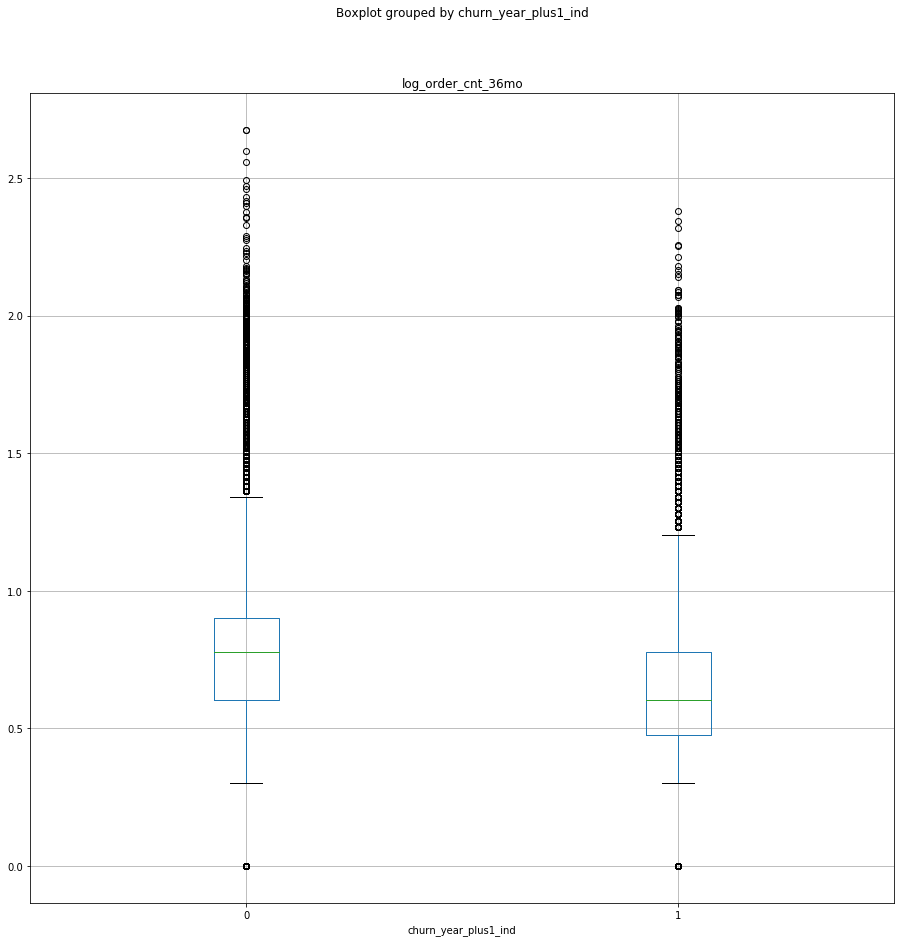

In [5]:
""" A boxplot to investigate the distribution of numeric variables by the levels of the target """

combined_df.boxplot(column='log_order_cnt_36mo', by='churn_year_plus1_ind',figsize=(15,15))

## Printing variable stats:

In [6]:
print(" summary stats on combined data ") 
print(combined_df.describe(include='all').transpose())

 summary stats on combined data 
                          count unique         top   freq         mean  \
ST                        73384     59          CA   6641          NaN   
Zip                       73384  18351     missing    282          NaN   
DMA                       73384    216         803   3012          NaN   
Area_Cd                   73384    328     missing   3849          NaN   
emailable                 73384    NaN         NaN    NaN      0.51777   
solicit_ph_ind            73384    NaN         NaN    NaN     0.891557   
solicit_email_ind         73384    NaN         NaN    NaN     0.963752   
fixd_incm_flg             73384    NaN         NaN    NaN    0.0919138   
scheduled_purchase_flg    73384    NaN         NaN    NaN     0.264772   
months_since_last_trans   73384    NaN         NaN    NaN      2.90521   
months_since_first_trans  73384    NaN         NaN    NaN      65.3361   
purch_avg_interval        73384    NaN         NaN    NaN       4.8528   
mail_

## Dropping variables we don't want included in modeling, and creating new version of data for modeling:

In [7]:
""" Any categorical variable for which we did not create dummy indicators        """
"""    and other variables we don't want in the model, or which don't make sense """
"""    to be included in model training, we are dropping here:                   """

""" Note:  we also want to drop acct_ID, but we are going to do that after partioning """
"""        because we need acct_ID for partioned sets to for reference later          """

x_train_df = combined_df.drop(['Zip','DMA','Area_Cd','activation_date','event_date',
                            'ST','tier','tier_prev'
                              ],axis=1)

x_train_df.shape

(73384, 103)

## Partitioning data into Training and Test sets, creating X vs Y sets, and
##     creating dataframes with just account IDs to be used to rejoin data later:

In [8]:
x_train_df, x_test_df = train_test_split(x_train_df, test_size = 0.30)

""" will need the acct_IDs to rejoin data later, so pulling out now before dropping from actual model training data """

train_acct_IDs_df = x_train_df[['acct_ID']]
test_acct_IDs_df  = x_test_df[['acct_ID']]

""" the target (or dependent) variable is stored in it's own dataframe """

y_train_df = x_train_df[['churn_year_plus1_ind']]
y_test_df  = x_test_df[['churn_year_plus1_ind']]

""" and we want to drop acct_ID and the target variable from the dataframe of independent variables """
""" PLUS we want to drop the target (future timeframe) variables for margin modeling                """

x_train_df = x_train_df.drop(['acct_ID','churn_year_plus1_ind', 'log_margin_Y_pos_1', 'margin_Y_pos_1'
                             ],axis=1)

x_test_df = x_test_df.drop(['acct_ID','churn_year_plus1_ind', 'log_margin_Y_pos_1', 'margin_Y_pos_1'
                             ],axis=1)

x_train_df.shape

(51368, 99)

## Starting with a scikit_learn Logistic Regression Model
##    and using that modeling algorithm to select variables.

## Note:  change the C parameter and rerun to get reasonable number of selected vars.

In [9]:
""" models penalized with the L1 norm have sparse solutions: many of their estimated coefficients are zero """
""" SelectFromModel can be used to to select effects with non-zero coefficients """
""" the parameter C controls the sparsity: the smaller C the fewer features selected """

""" using the ravel simply to avoid warning in log """
y_train_array=np.ravel(y_train_df)

""" start with C = 1.0, then try 0.1, etc """
model1 = linear_model.LogisticRegression(C=0.01, solver='liblinear', penalty='l1', tol=0.01)
model1_fit = model1.fit(x_train_df, y_train_array)
model1_selects = SelectFromModel(model1_fit, prefit=True)
"""x_train_selected_df = model1_selects.transform(x_train_df)"""

""" in lieu of commented-out transform method above, can use this method to explicitly define columns to keep """
x_train_selected_df = x_train_df[x_train_df.columns[model1_selects.get_support()]]
x_test_selected_df  = x_test_df[x_test_df.columns[model1_selects.get_support()]]

coefficients = pd.DataFrame(model1_fit.coef_)
coefficients = np.transpose(coefficients[coefficients.columns[model1_selects.get_support()]])
coefficients = coefficients.reset_index(drop=True)

coefficients_match = pd.concat([pd.DataFrame(x_train_selected_df.columns),coefficients], axis = 1)

coefficients.shape 

(25, 1)

In [10]:
print(" ") 
print("Coefficients for selected variables")
coefficients_match.head(40)

 
Coefficients for selected variables


,0,0
0,emailable,-0.059250
1,scheduled_purchase_flg,-3.562582
2,months_since_last_trans,0.418122
3,months_since_first_trans,-0.004316
4,purch_avg_interval,0.005266
5,mail_cnt_36mo,-0.010414
6,call_in_mo_36mo,-0.001213
7,call_out_mo_36mo,-0.043681
8,log_order_cnt_36mo,-0.051082
9,log_purch_amt_36mo,-0.031643


## Need to introduce variable reduction that addresses multicolinearity:

In [11]:
x_train_selected_df.shape

(51368, 25)

In [23]:
from statsmodels.stats.outliers_influence import variance_inflation_factor    

def calculate_vif_(X, thresh=10):
    cols = X.columns
    variables = np.arange(X.shape[1])
    dropped=True
    while dropped:
        dropped=False
        c = X[cols[variables]].values
        vif = [variance_inflation_factor(c, ix) for ix in np.arange(c.shape[1])]
        maxloc = vif.index(max(vif))
    if max(vif) > thresh:
        print('dropping \'' + X[cols[variables]].columns[maxloc] + '\' at index: ' + str(maxloc))
        variables = np.delete(variables, maxloc)
        dropped=True
        
        print('Remaining variables:')
        print(X.columns[variables])
    return X.iloc[:, variables]

x_train_selected_df=calculate_vif_(x_train_selected_df, 10.0)
        
x_train_selected_df.shape

(51368, 15)

## Run the step above, repeatedly, until no more variables are dropped.

In [24]:
""" reducing the test set to have the same columns as the training set """

x_test_selected_df=x_test_selected_df[x_train_selected_df.columns]
print('Remaining variables in test set:')
print(x_test_selected_df.columns)
        
x_test_selected_df.shape

Remaining variables in test set:
Index(['emailable', 'scheduled_purchase_flg', 'months_since_last_trans',
       'months_since_first_trans', 'purch_avg_interval', 'mail_cnt_36mo',
       'call_in_mo_36mo', 'call_out_mo_36mo', 'log_order_cnt_36mo',
       'log_resp_cnt_36mo', 'perc_purch_ck_36mo', 'perc_purch_et_36mo',
       'margin_Y_neg_2', 'margin_Y_neg_3', 'tier_prev_xxx'],
      dtype='object')


(22016, 15)

## Using the statsmodels package to see "friendlier" looking Logistic output:

In [25]:
""" for the statsmodels, need to add a constant to fit intercept """

x_train_selected_df = sm.add_constant(x_train_selected_df, has_constant='add')
x_test_selected_df  = sm.add_constant(x_test_selected_df, has_constant='add')

""" modeling with selected variables from steps above """

model = sm.Logit(y_train_df, x_train_selected_df)
result = model.fit(maxiter=100)

print(" ") 
print("Logistic model with selected variables")
print(" ") 
print(result.summary2())
print('AIC: ', result.aic)
print('BIC: ', result.bic)

Optimization terminated successfully.
         Current function value: 0.320490
         Iterations 9
 
Logistic model with selected variables
 
                             Results: Logit
Model:                Logit                 Pseudo R-squared:  0.443     
Dependent Variable:   churn_year_plus1_ind  AIC:               32957.8920
Date:                 2018-10-07 15:11      BIC:               33099.4403
No. Observations:     51368                 Log-Likelihood:    -16463.   
Df Model:             15                    LL-Null:           -29553.   
Df Residuals:         51352                 LLR p-value:       0.0000    
Converged:            1.0000                Scale:             1.0000    
No. Iterations:       9.0000                                             
-------------------------------------------------------------------------
                          Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
-----------------------------------------------------------------------

## Using the statsmodels Logit model to score the data and evaluate goodness-of-fit:

AROC train:  0.9173064170238517
AROC test:  0.9194730195228641
 
MSE train: 0.10082047636406873
MSE test: 0.09931608588160566
 
testing that the joining process works. if so, these MSE should match the ones above.
mean squared error train: 0.10082047636406931
mean squared error testn: 0.09931608588160626


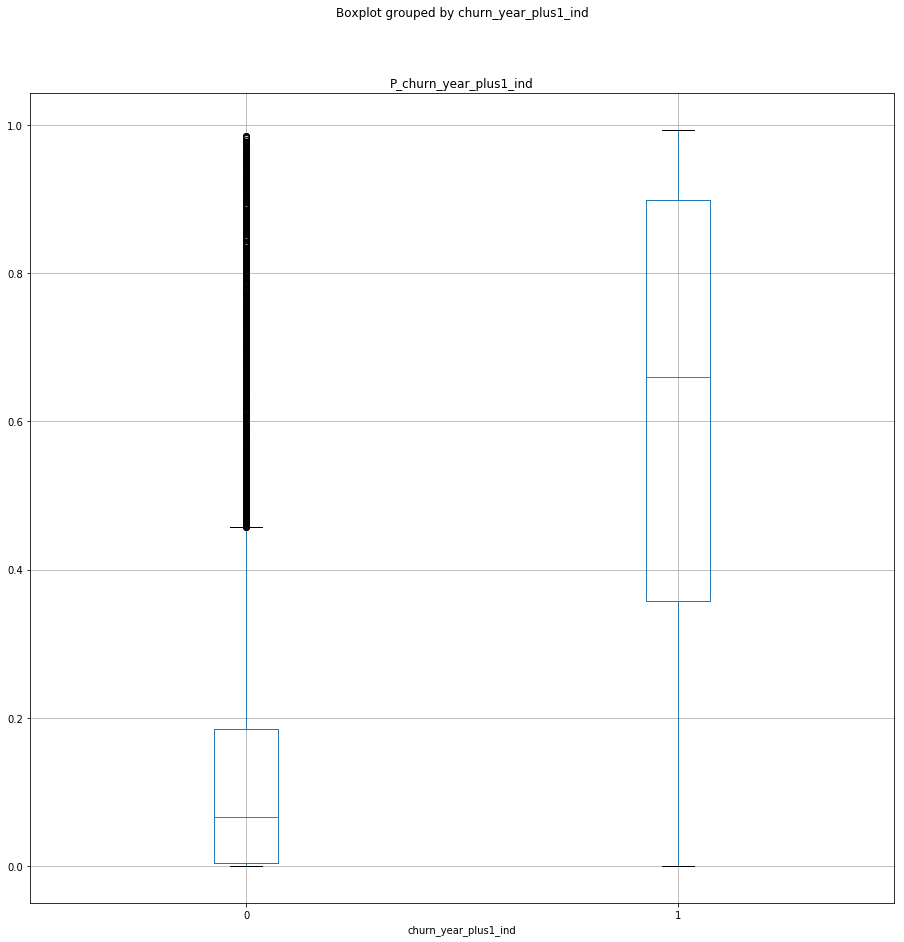

In [26]:
""" predicted values using the model """
""" using numpy copy to store result as an array """
""" manually adding a column header """
predict_train = pd.DataFrame(np.copy(result.predict(x_train_selected_df)), columns=["P_churn_year_plus1_ind"])
predict_test = pd.DataFrame(np.copy(result.predict(x_test_selected_df)), columns=["P_churn_year_plus1_ind"])

print ('AROC train: ', metrics.roc_auc_score(y_train_df, predict_train))
print ('AROC test: ', metrics.roc_auc_score(y_test_df, predict_test))

""" note that the index for the predicted values vector """
""" is reset, and thus complicates a join back with the original """
""" thus, reset the index on the original data, then join with predicted """
""" WARNING: you have to do the same, to join back with dataframe of regressors """
y_train_df = y_train_df.reset_index(drop=True)
y_test_df = y_test_df.reset_index(drop=True)

""" joining predicted and actuals """
""" NOTE:  for reference, for now...to be used more later to create complete """
"""     dataframe with all obs and inputs and outputs """
train_accounts = train_acct_IDs_df.reset_index(drop=True)
pred_v_actual_train = y_train_df.join(predict_train)
pred_v_actual_train = pred_v_actual_train.join(train_accounts)

test_accounts = test_acct_IDs_df.reset_index(drop=True)
pred_v_actual_test = y_test_df.join(predict_test)
pred_v_actual_test = pred_v_actual_test.join(test_accounts)

print(" ") 
print("MSE train:", mean_squared_error(y_train_df, predict_train))
print("MSE test:", mean_squared_error(y_test_df, predict_test))

print(" ") 
print("testing that the joining process works. if so, these MSE should match the ones above.")
print("mean squared error train:" , (np.mean((pred_v_actual_train['churn_year_plus1_ind']-pred_v_actual_train['P_churn_year_plus1_ind'])**2)))
print("mean squared error testn:" , (np.mean((pred_v_actual_test['churn_year_plus1_ind']-pred_v_actual_test['P_churn_year_plus1_ind'])**2)))

pred_v_actual_test.boxplot(column='P_churn_year_plus1_ind', by='churn_year_plus1_ind',figsize=(15,15))

## Now to try a more advanced Machine Learning algorithm to see if we can get a better model:

GB overall accuracy: 0.878406613372093
AROC train:  0.9402891855955475
AROC test:  0.9364216996081296
 
MSE train: 0.08477205537949323
MSE test: 0.08781895887747418
 
testing that the joining process works. if so, these MSE should match the ones above.
mean squared error train: 0.08477205537949405
mean squared error test: 0.0878189588774741


Text(0,0.5,'AROC')

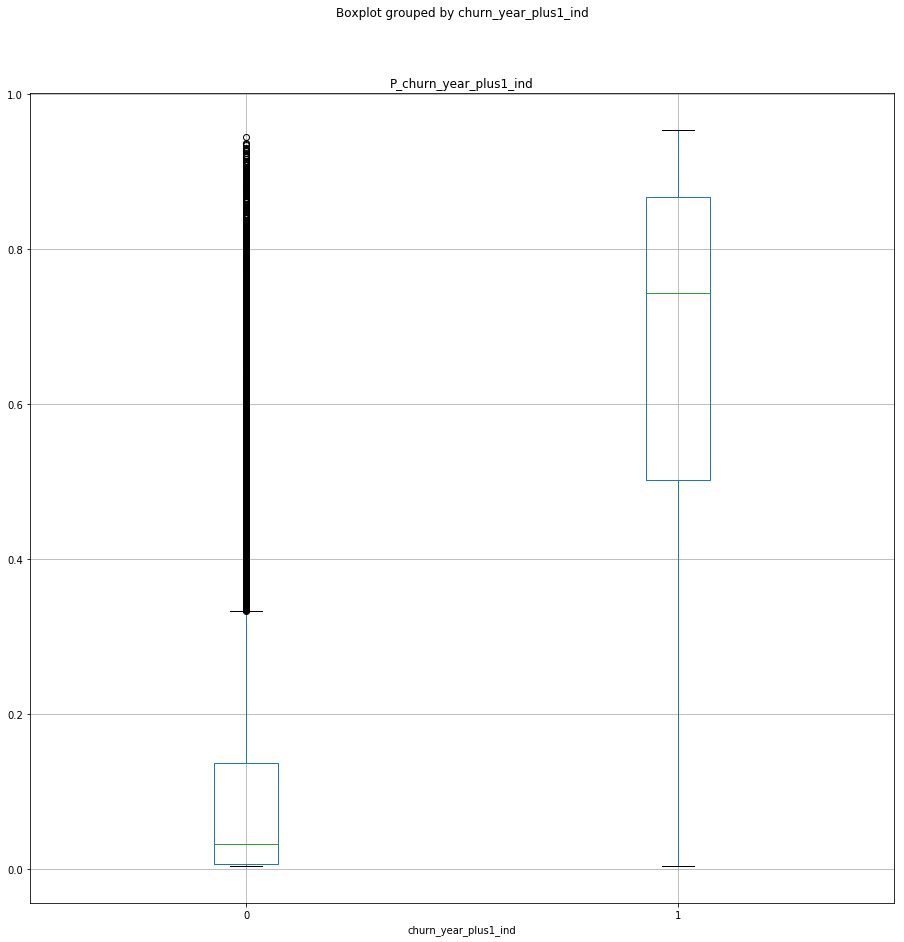

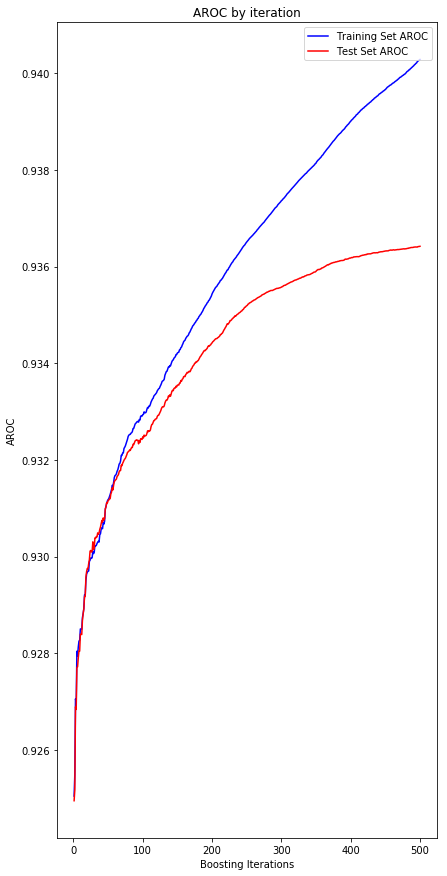

In [27]:
""" Gradient Boosting """
params = {'n_estimators': 500, 'min_samples_split': 2,  'max_depth': 5, 'learning_rate': 0.01}
model2 = GradientBoostingClassifier(**params)

""" had to switch the order of X and Y for the fit to work with GradientBoosting """
result = model2.fit(x_train_selected_df, y_train_array)

""" returns overall accuracy"""
accuracy = model2.score(x_test_selected_df, y_test_df)
print("GB overall accuracy:", accuracy)

""" predicted values using the model """
""" using numpy copy to store result as an array """
""" manually adding a column header """
predict_train = pd.DataFrame(np.copy(model2.predict_proba(x_train_selected_df)[:, 1]), columns=["P_churn_year_plus1_ind"])
predict_test = pd.DataFrame(np.copy(model2.predict_proba(x_test_selected_df)[:, 1]), columns=["P_churn_year_plus1_ind"])

print ('AROC train: ', metrics.roc_auc_score(y_train_df, predict_train))
print ('AROC test: ', metrics.roc_auc_score(y_test_df, predict_test))

""" note that the index for the predicted values vector """
""" is reset, and thus complicates a join back with the original """
""" thus, reset the index on the original data, then join with predicted """
""" WARNING: you have to do the same, to join back with dataframe of regressors """
y_train_df = y_train_df.reset_index(drop=True)
y_test_df = y_test_df.reset_index(drop=True)

train_accounts = train_acct_IDs_df.reset_index(drop=True)
pred_v_actual_train = y_train_df.join(predict_train)
pred_v_actual_train = pred_v_actual_train.join(train_accounts)


test_accounts = test_acct_IDs_df.reset_index(drop=True)
pred_v_actual_test = y_test_df.join(predict_test)
pred_v_actual_test = pred_v_actual_test.join(test_accounts)

print(" ") 
print("MSE train:", mean_squared_error(y_train_df, predict_train))
print("MSE test:", mean_squared_error(y_test_df, predict_test))

print(" ") 
print("testing that the joining process works. if so, these MSE should match the ones above.")
print("mean squared error train:" , (np.mean((pred_v_actual_train['churn_year_plus1_ind']-pred_v_actual_train['P_churn_year_plus1_ind'])**2)))
print("mean squared error test:" , (np.mean((pred_v_actual_test['churn_year_plus1_ind']-pred_v_actual_test['P_churn_year_plus1_ind'])**2)))


pred_v_actual_test.boxplot(column='P_churn_year_plus1_ind', by='churn_year_plus1_ind',figsize=(15,15))

""" plotting AROC with each iteration of the Gradient Boosting algorithm """

""" converting Y dataframes into arrays as needed for logic below """
y_traint_array = y_train_df.values
y_test_array = y_test_df.values

test_AROC  = np.zeros((params['n_estimators'],), dtype=np.float64)
train_AROC = np.zeros((params['n_estimators'],), dtype=np.float64)

for i, y_pred in enumerate(model2.staged_predict_proba(x_test_selected_df)):
    test_AROC[i] = metrics.roc_auc_score(y_test_array, y_pred[:, 1])

for i, y_pred in enumerate(model2.staged_predict_proba(x_train_selected_df)):
    train_AROC[i] = metrics.roc_auc_score(y_train_array, y_pred[:, 1])

plt.figure(figsize=(15,15))
plt.subplot(1, 2, 1)
plt.title('AROC by iteration')
plt.plot(np.arange(params['n_estimators']) + 1, train_AROC, 'b-',
         label='Training Set AROC')
plt.plot(np.arange(params['n_estimators']) + 1, test_AROC, 'r-',
         label='Test Set AROC')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('AROC')


## Feature Importance for the Gradient Boosting Model:

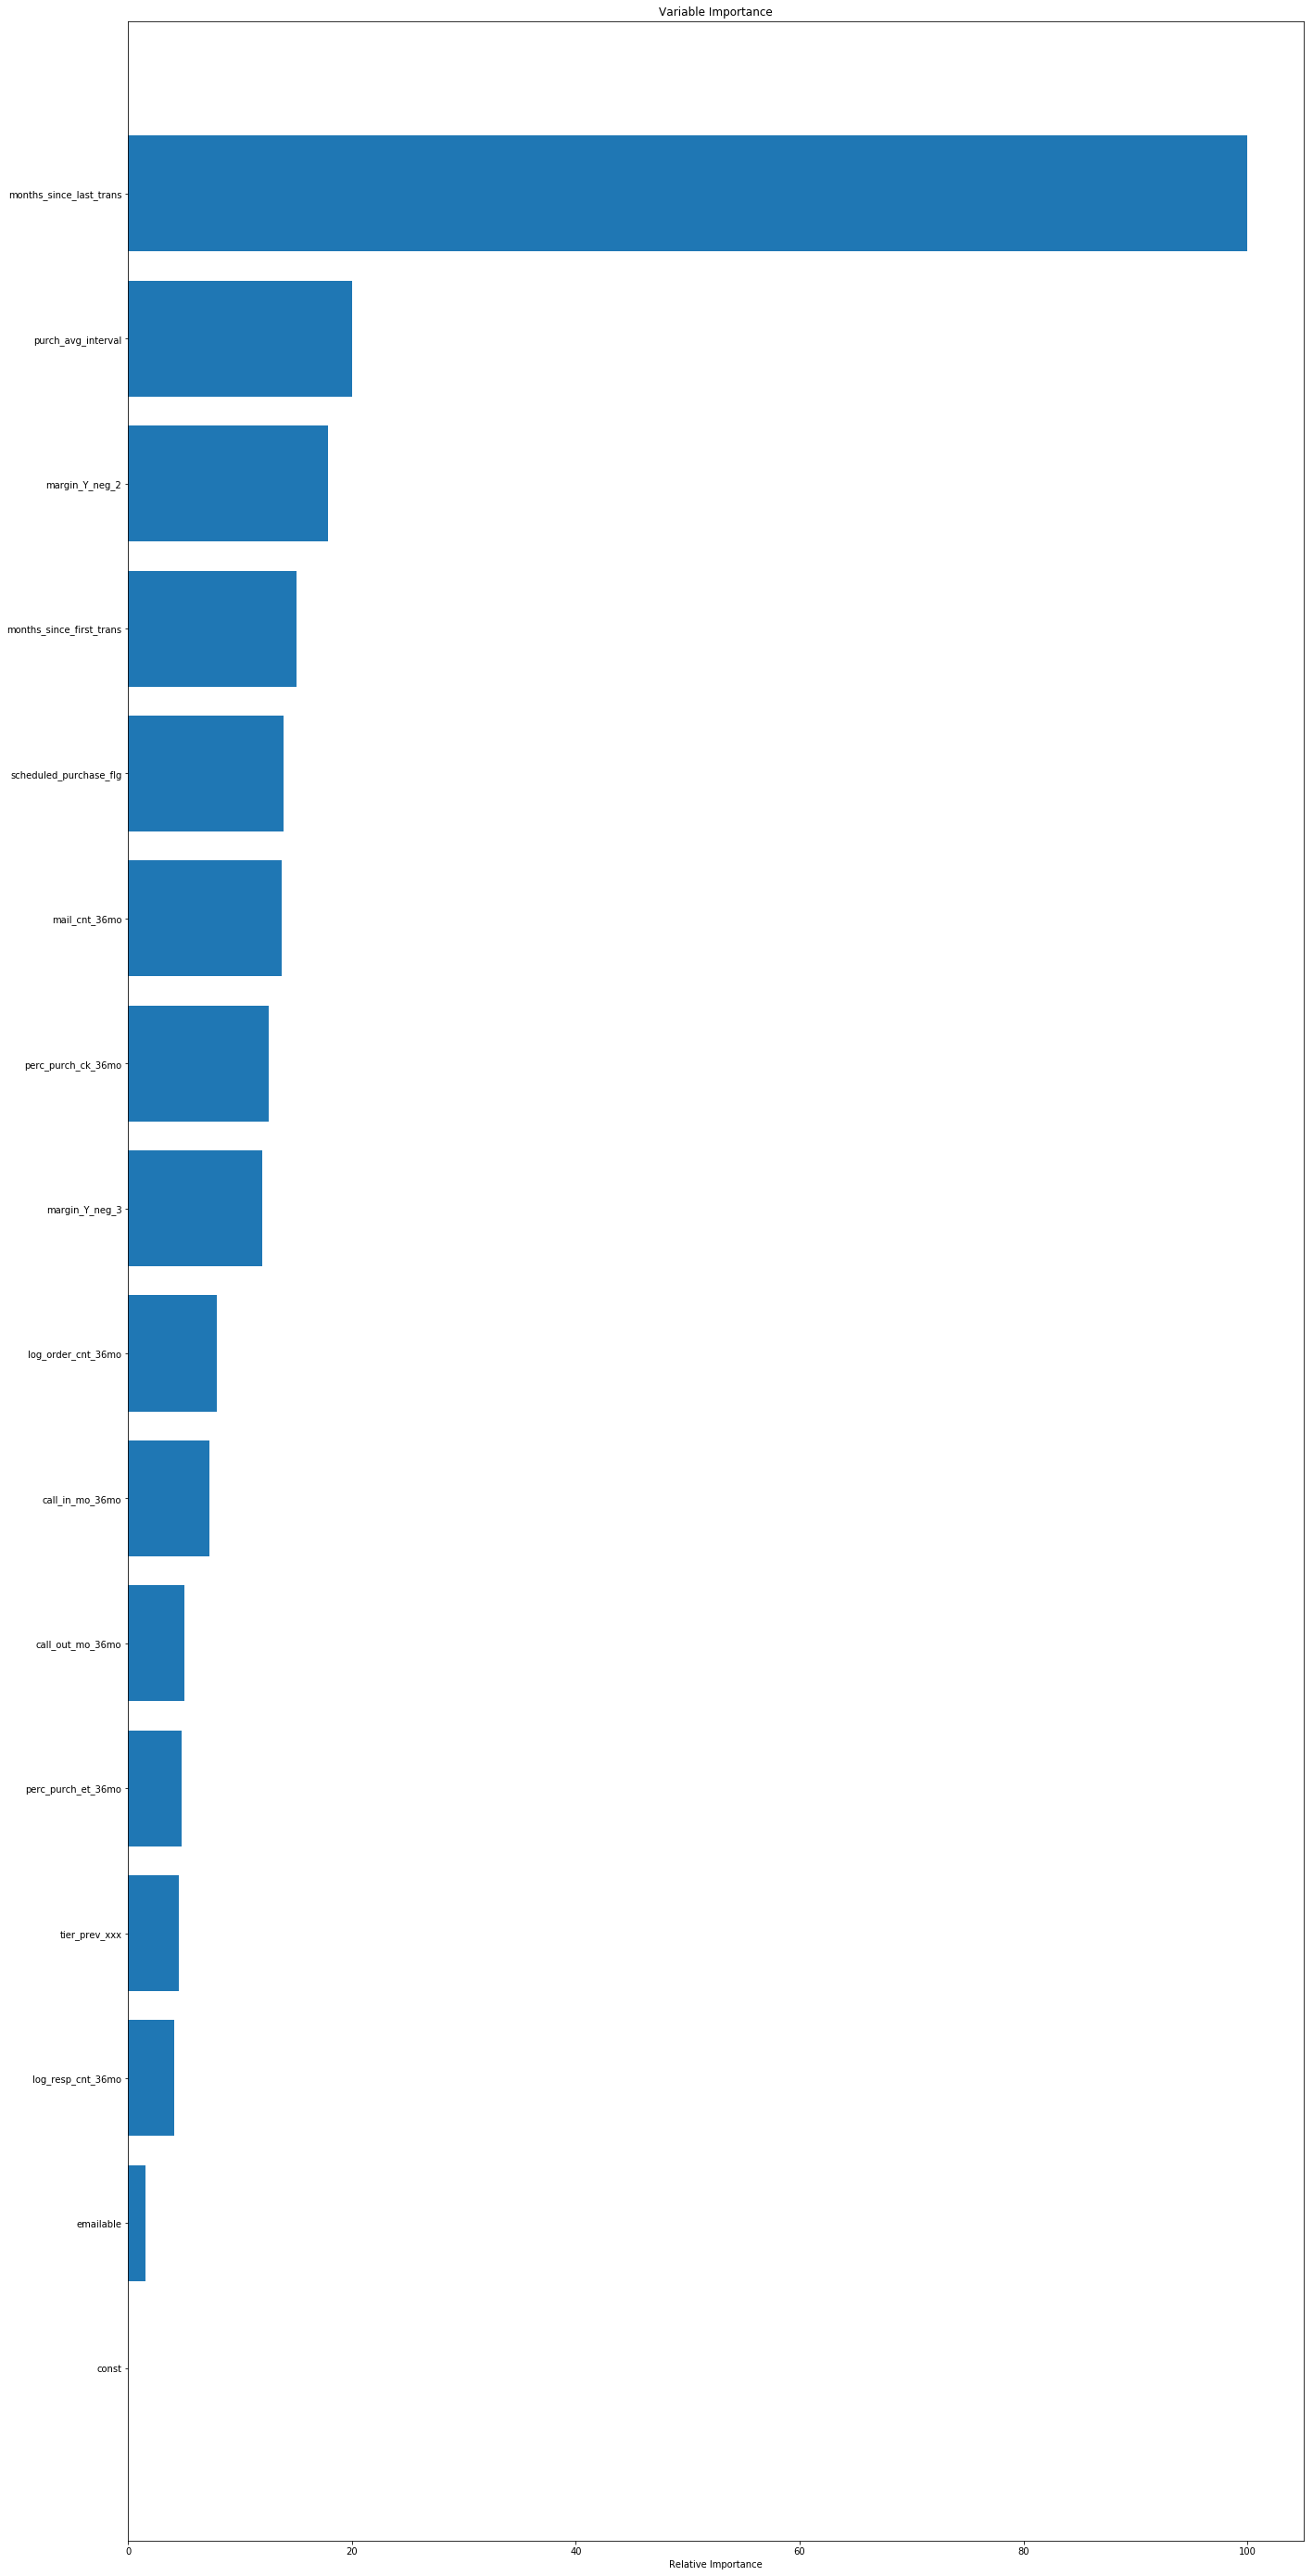

In [28]:
feature_importance = model2.feature_importances_
""" make importances relative to max importance """
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=(50,50))
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, x_train_selected_df.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

## Appending the train and test sets, and keeping the acct_IDs and predicted churn probabilities

In [29]:
""" append together train and test predicted values, keeping only acct ID and predicted values """

pred_v_actual_train=pred_v_actual_train.append(pred_v_actual_test, ignore_index=True)

pred_v_actual_train = pred_v_actual_train.drop(['churn_year_plus1_ind'
                             ],axis=1)

""" and then save predicted values by acct ID to csv """

pred_v_actual_train.to_csv('E:\OSU_CLV_Course\All_NEW_Fall_2018\Lab\churn_scores.csv',index=False)
pred_v_actual_train.shape

## (back to lecture mode)